## Histogram of trapEmax (calibrated using $y=0.4495x + 0.2385$)

In [1]:
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.utils as pgu
import pygama.analysis.peak_fitting as pgf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pk

import bisect as bs

import calibration_jdetwiler as cb


title_fontsize = 20
colors = ['b','g','r','c','y','m','k','maroon','dodgerblue','darkgoldenrod', 'gold',
         'darkslategray', 'orange']

## Peaks that are potentially usable/ have been used for calibration

In [2]:
usable_peaks = [
    ['212Pb', 239.6, 239.0, 2],
    ['214Pb', 295.1, 295.5, 3],
    ['214Pb', 351.9, 352.2, 6],
    ['208Tl', 583.2, 583.0, 6],
    ['214Bi', 609.32, 609.3, 10],
    ['228Ac', 911.2, 911, 7],
    ['214Bi', 1120.3, 1120, 3],
    ['40K', 1460.8, 1460.8, 15],
    ['214Bi', 1764.5, 1764.5, 10]
]
df = pd.DataFrame(usable_peaks, 
                  columns=['Isotopes','true_values (keV)', 'values_on_data(keV)', 'event/bkg'])

df['Diff (keV)'] = abs(df['true_values (keV)']-df['values_on_data(keV)'])
df['event/bkg/diff'] = df['event/bkg']/df['Diff (keV)']
pd.options.display.float_format = '{:,.1f}'.format
df

,Isotopes,true_values (keV),values_on_data(keV),event/bkg,Diff (keV),event/bkg/diff
0,212Pb,239.6,239.0,2,0.6,3.3
1,214Pb,295.1,295.5,3,0.4,7.5
2,214Pb,351.9,352.2,6,0.3,20.0
3,208Tl,583.2,583.0,6,0.2,30.0
4,214Bi,609.3,609.3,10,0.0,500.0
5,228Ac,911.2,911.0,7,0.2,35.0
6,214Bi,"1,120.3","1,120.0",3,0.3,10.0
7,40K,"1,460.8","1,460.8",15,0.0,inf
8,214Bi,"1,764.5","1,764.5",10,0.0,inf


## Peaks that are not in the known peak list but present in data
- 186.1
- 273.5
- 409.3
- 463.1
- 546.9
- Double peak at 679 and 683
- 727.5
- 1587.9

<ipython-input-3-5924e77027f5>:10: RuntimeWarning: invalid value encountered in true_divide
  imaxes, imins = cb.get_i_local_extrema(hist/np.sqrt(var), n_sigma)


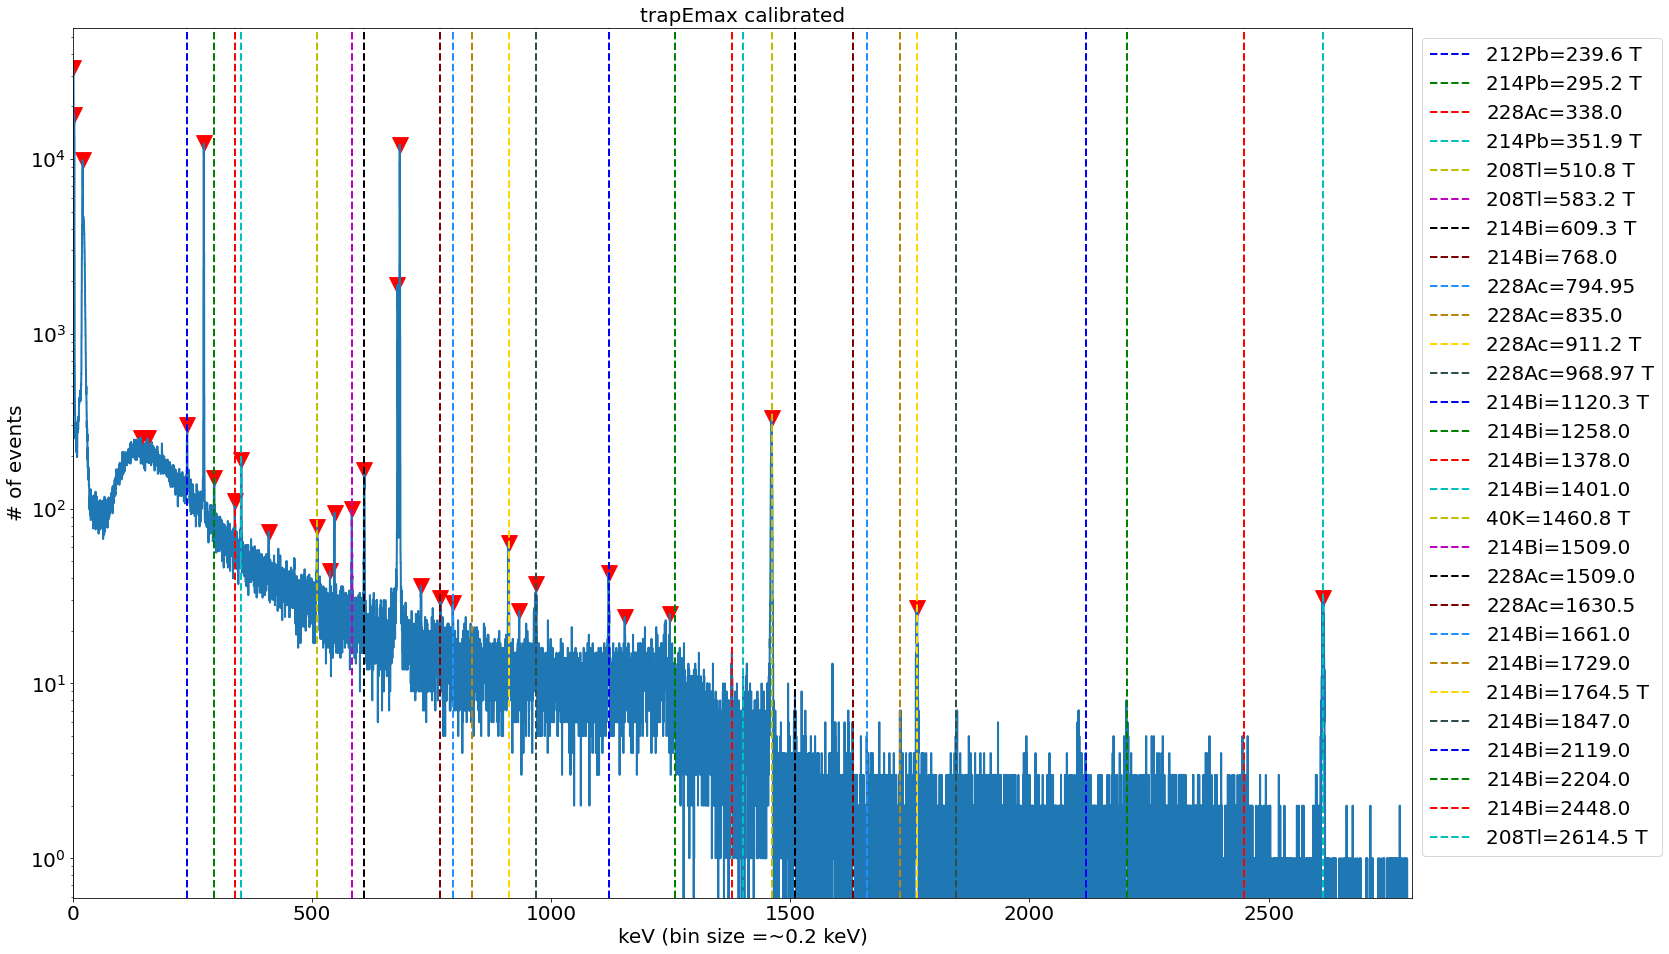

,max bins,bin centers,value,uncertainty
0,4,0.9,33350,182.6
1,14,2.9,17762,133.3
2,102,20.5,9868,99.3
3,712,142.5,255,16.0
4,780,156.1,252,15.9
5,1195,239.1,299,17.3
6,1368,273.7,12272,110.8
7,1476,295.3,149,12.2
8,1691,338.3,111,10.5
9,1761,352.3,190,13.8


In [3]:
energy_calibrated = pk.load(open('trapEmax_calibrated.pk','rb'))
peak_list = pd.read_csv('peak_list.txt', delimiter=' ')

n_bins = 15000
adc_range = (0,3000)
hist, bins, var = pgh.get_hist(energy_calibrated, bins = n_bins, 
                               range=adc_range)

n_sigma = 3
imaxes, imins = cb.get_i_local_extrema(hist/np.sqrt(var), n_sigma)
bin_centers = pgh.get_bin_centers(bins)


peak_list_tall = peak_list[peak_list.iloc[:,2]=='T']
#peak_list_tall
#T=Tall means yes you might be able to calibrate with this
def print_a_range(x_min, x_max, tall_peaks=False, figsize=(24,16)):
    plt.figure(figsize=figsize)
    pgh.plot_hist(hist, bins, lw=2)
    plt.scatter(bin_centers[imaxes], hist[imaxes], color='r', s=250, marker='v')
    color_index=0
    peak_list_to_plot = peak_list
    if tall_peaks: peak_list_to_plot = peak_list_tall
    color_index=0
    for i in range(peak_list_to_plot.shape[0]):
        label = ''
        if peak_list_to_plot.iloc[i,1]<x_max and peak_list_to_plot.iloc[i,1]>x_min:
            is_tall_label=''
            if peak_list_to_plot.iloc[i,2]=='T': is_tall_label=' T'
            label = peak_list_to_plot.iloc[i,0]+'='+str(peak_list_to_plot.iloc[i,1])+is_tall_label
        plt.axvline(x=peak_list_to_plot.iloc[i,1], label=label, 
                        color=colors[color_index%12], ls='--', lw=2)
        color_index+=1
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=title_fontsize)
    plt.title('trapEmax calibrated', fontsize=title_fontsize)
    plt.yscale('log')
    plt.xlim(x_min,x_max)
    plt.xticks(fontsize=title_fontsize)
    plt.yticks(fontsize=title_fontsize)
    plt.xlabel('keV (bin size =~'+str(adc_range[1]/n_bins)+' keV)',fontsize=title_fontsize)
    plt.ylabel('# of events',fontsize=title_fontsize)
    plt.show()
print_a_range(0,2800)
tup = {'max bins':imaxes,
       'bin centers':bin_centers[imaxes],
       'value':hist[imaxes],
       'uncertainty':np.sqrt(var[imaxes])
      }
pd.DataFrame(tup)

No handles with labels found to put in legend.


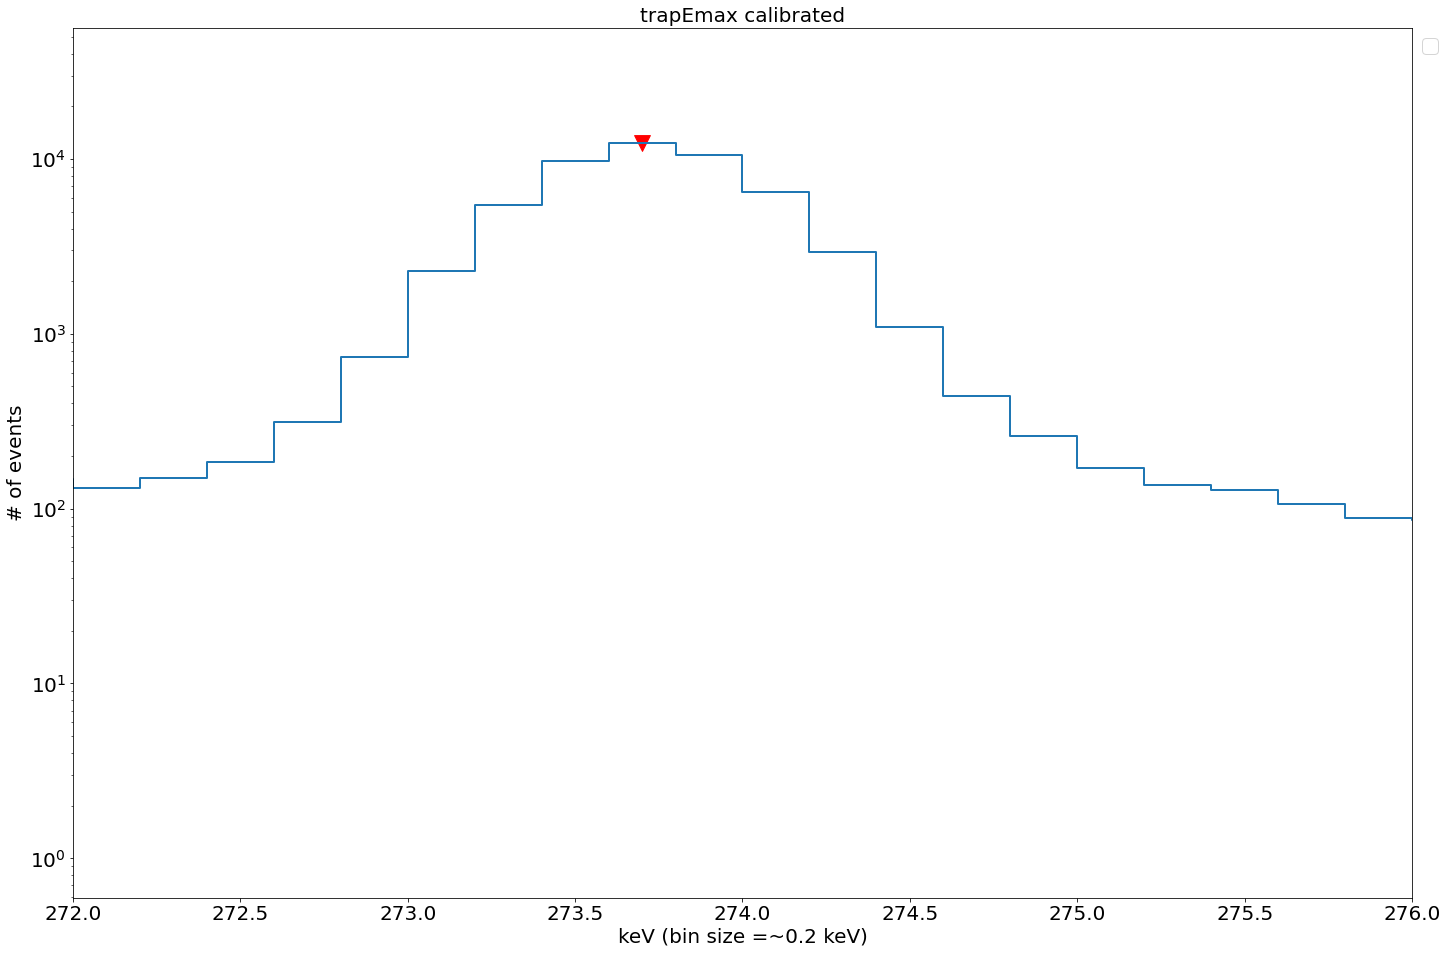

In [4]:
print_a_range(272,276)

No handles with labels found to put in legend.


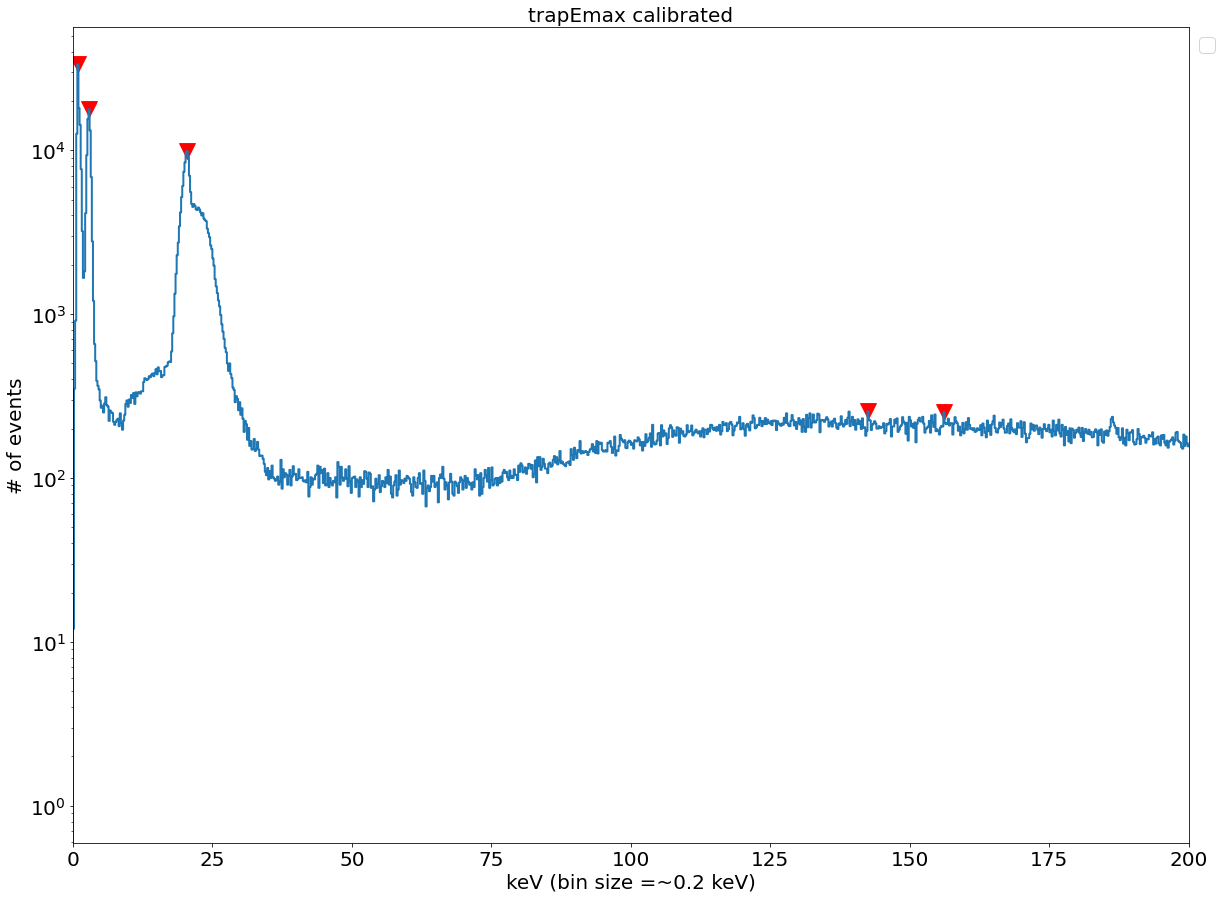

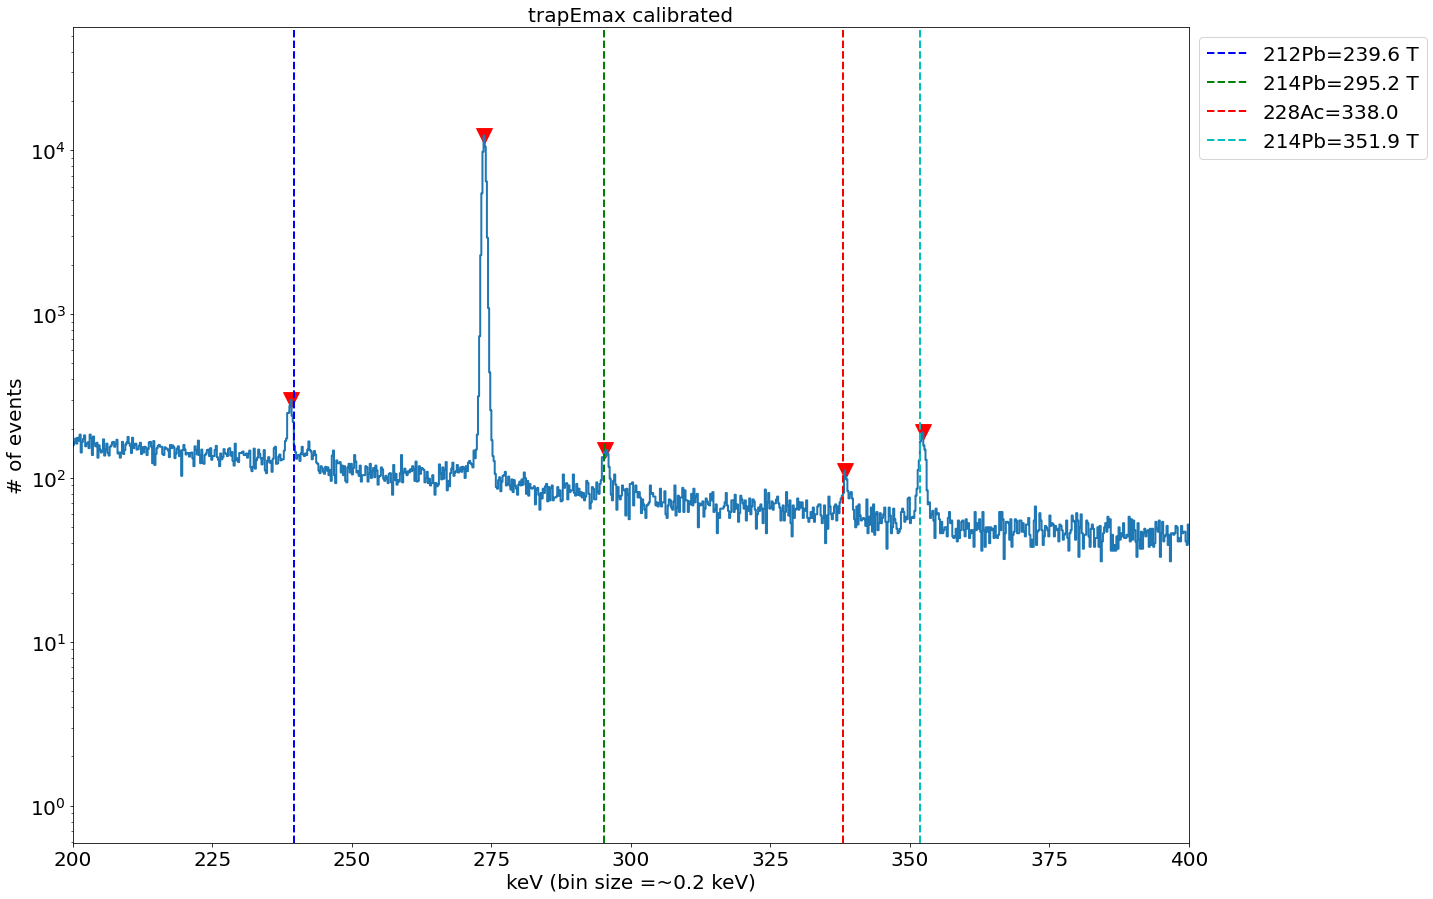

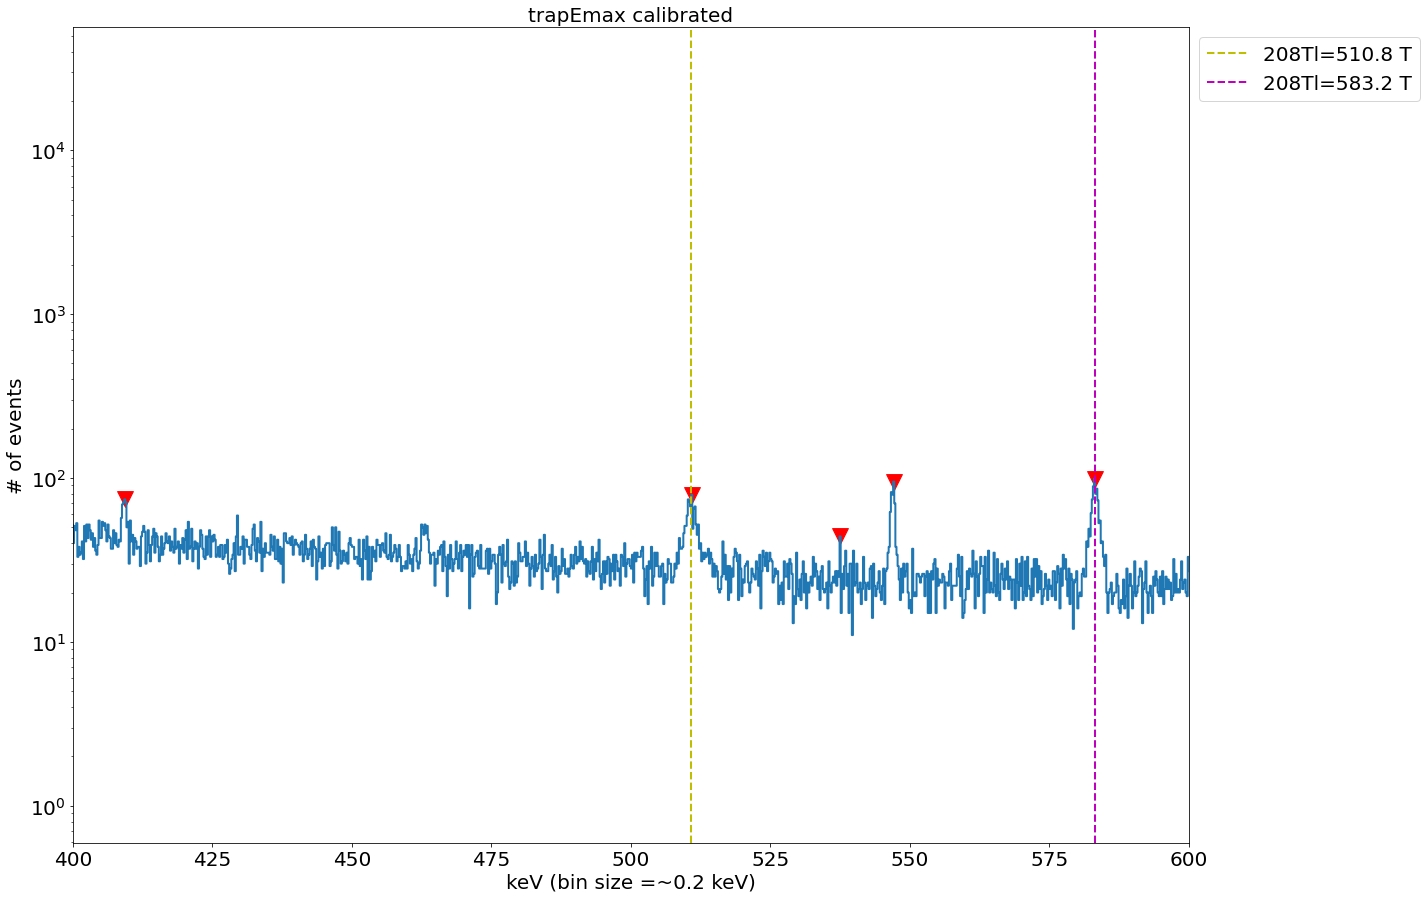

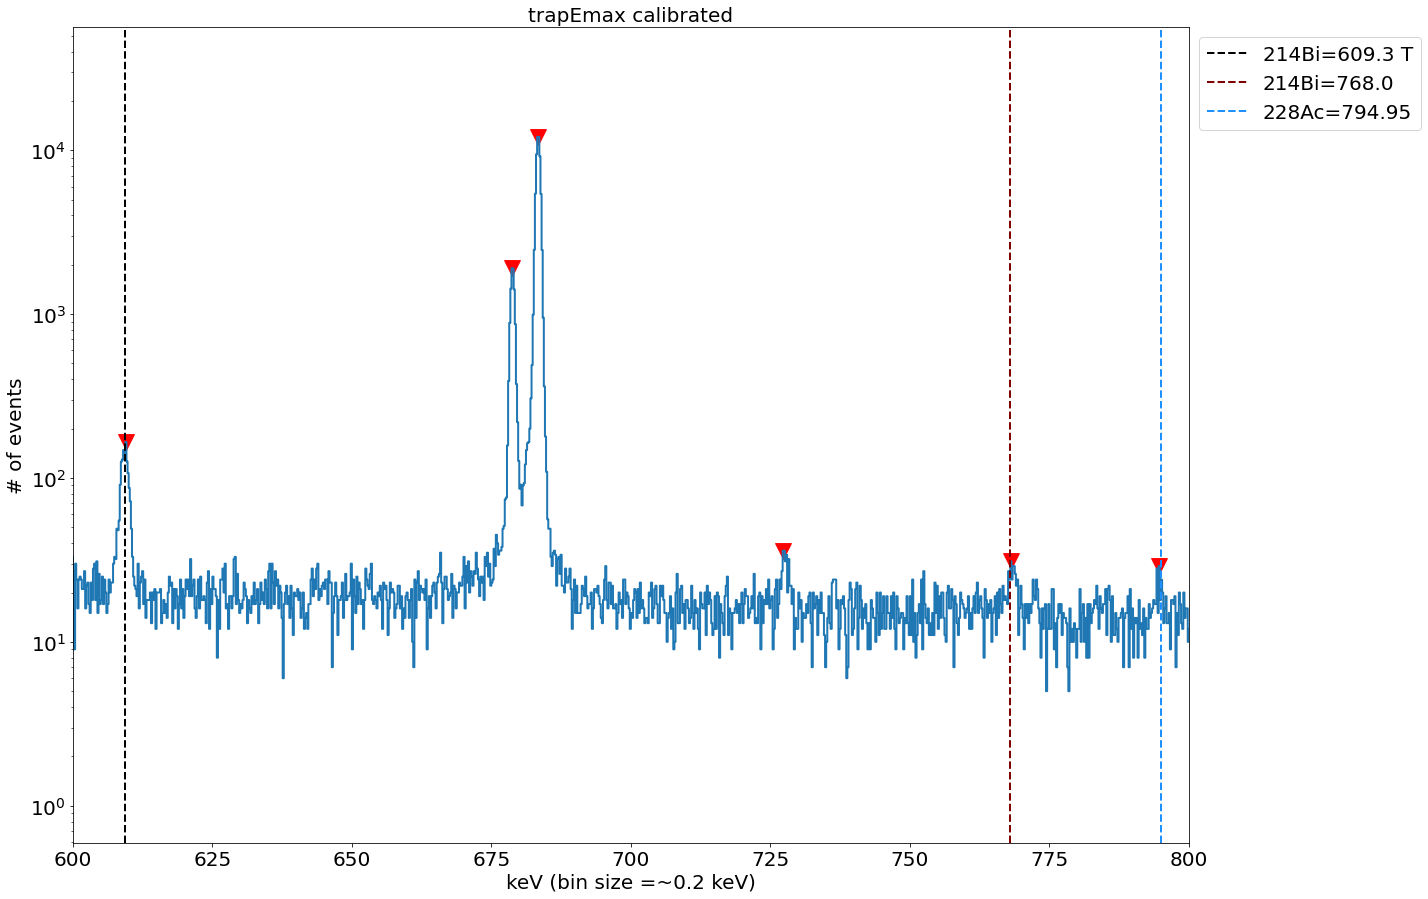

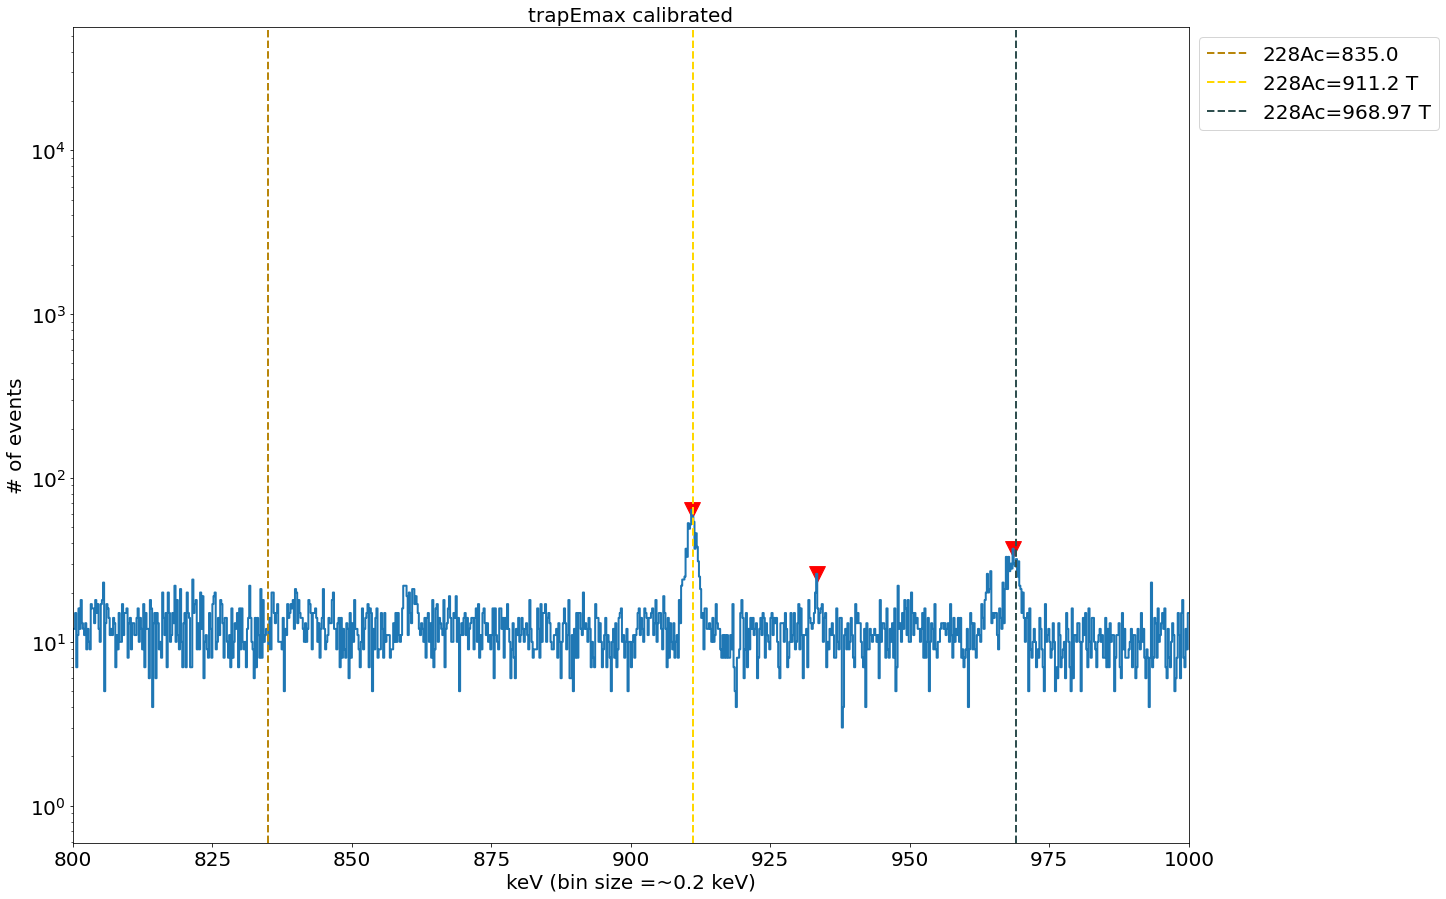

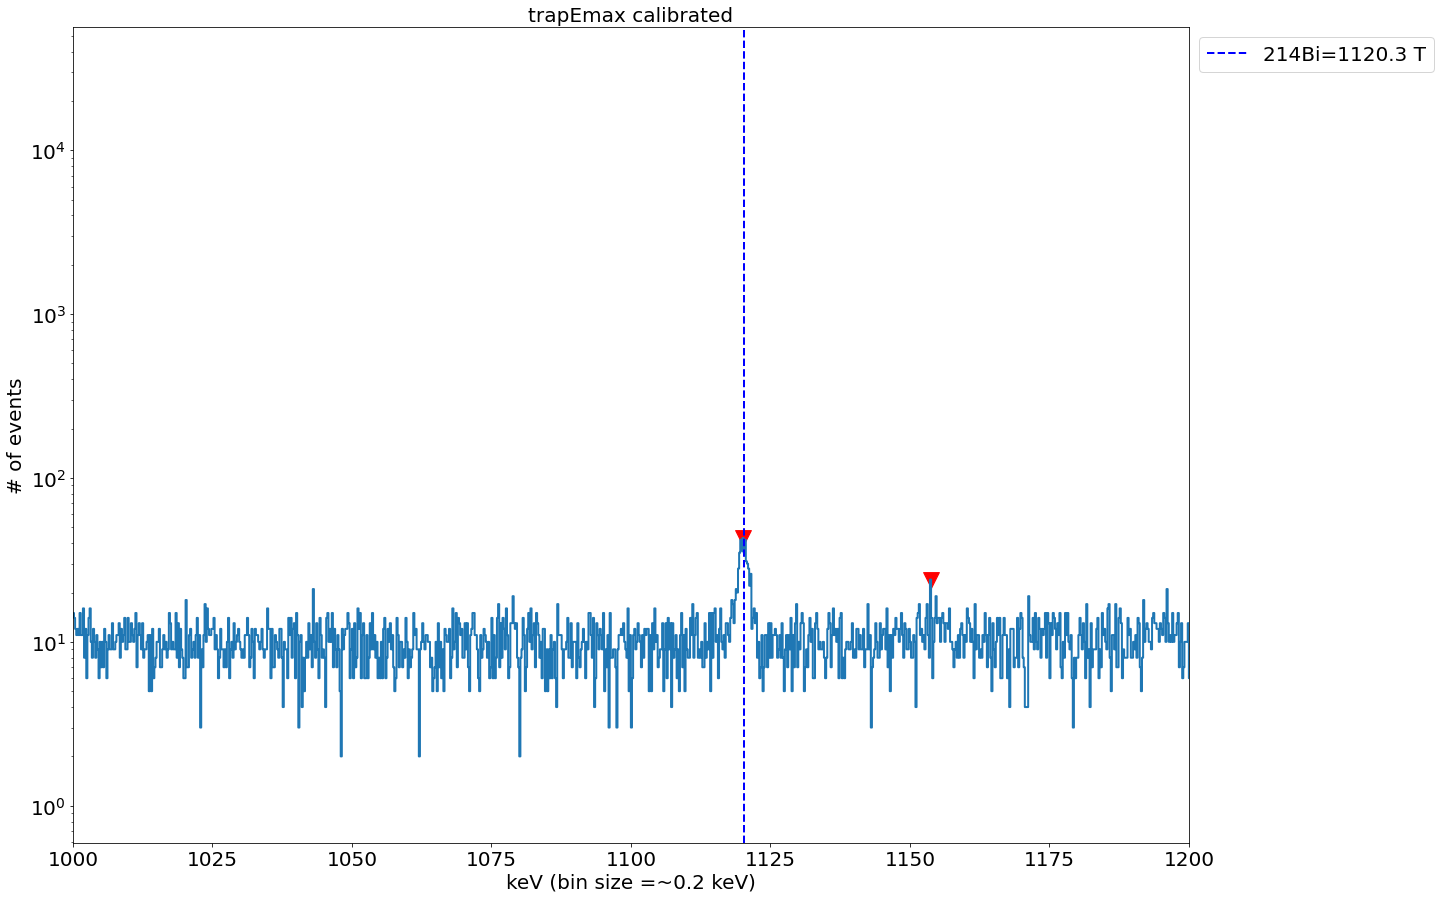

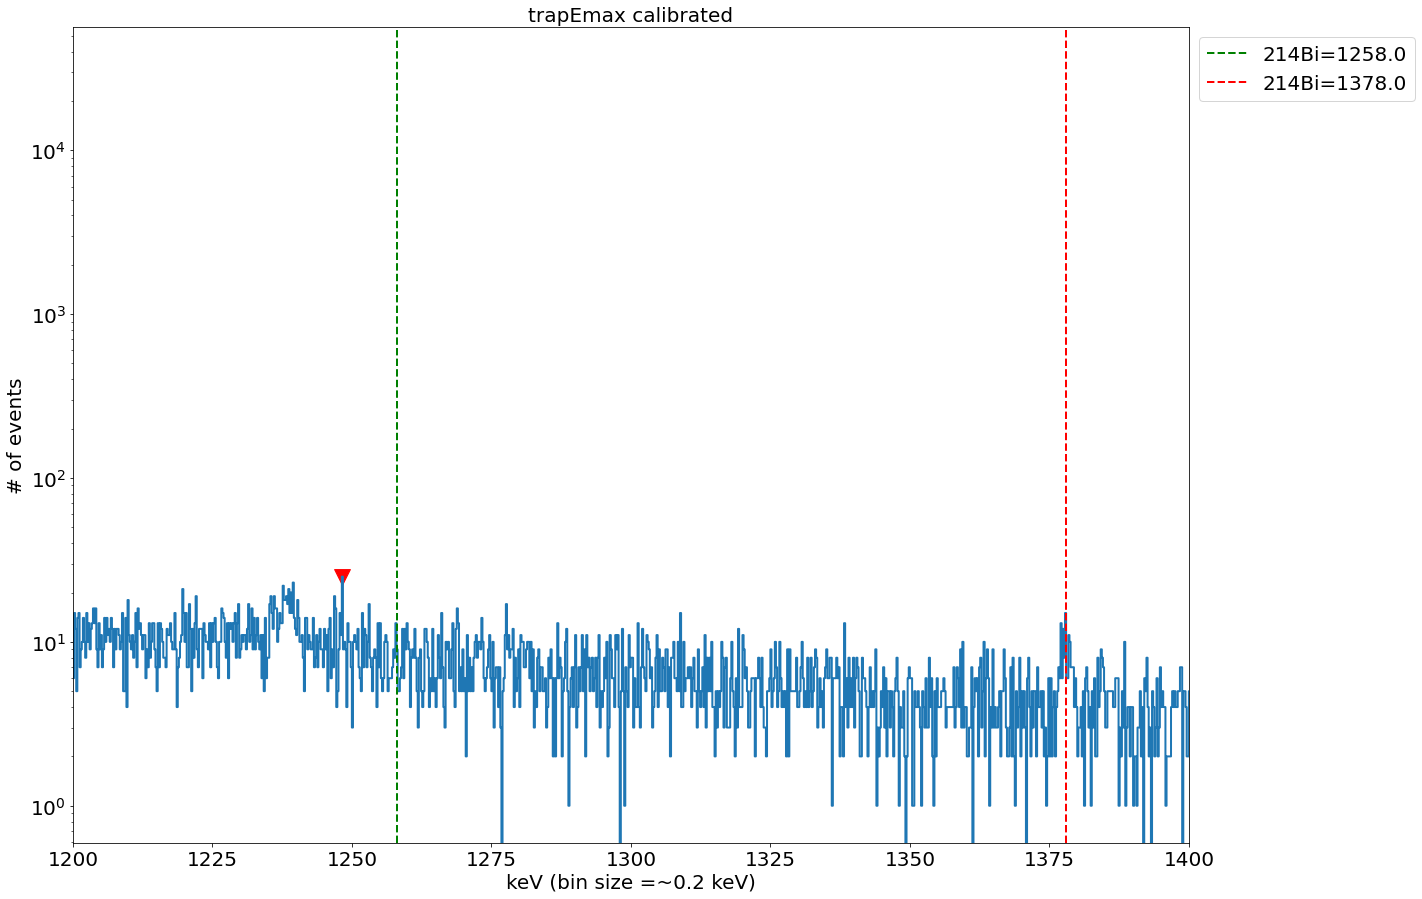

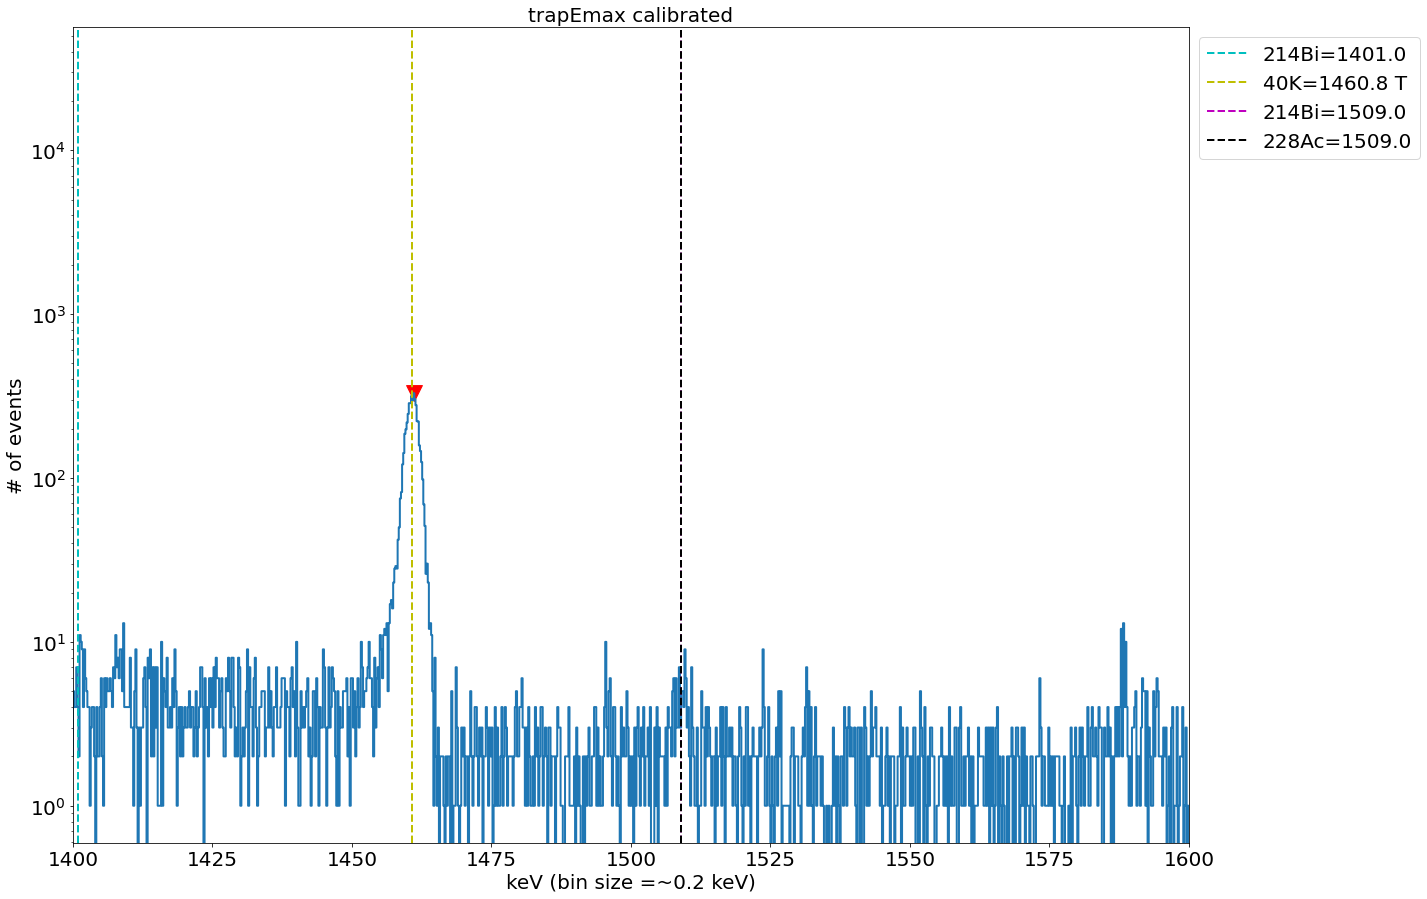

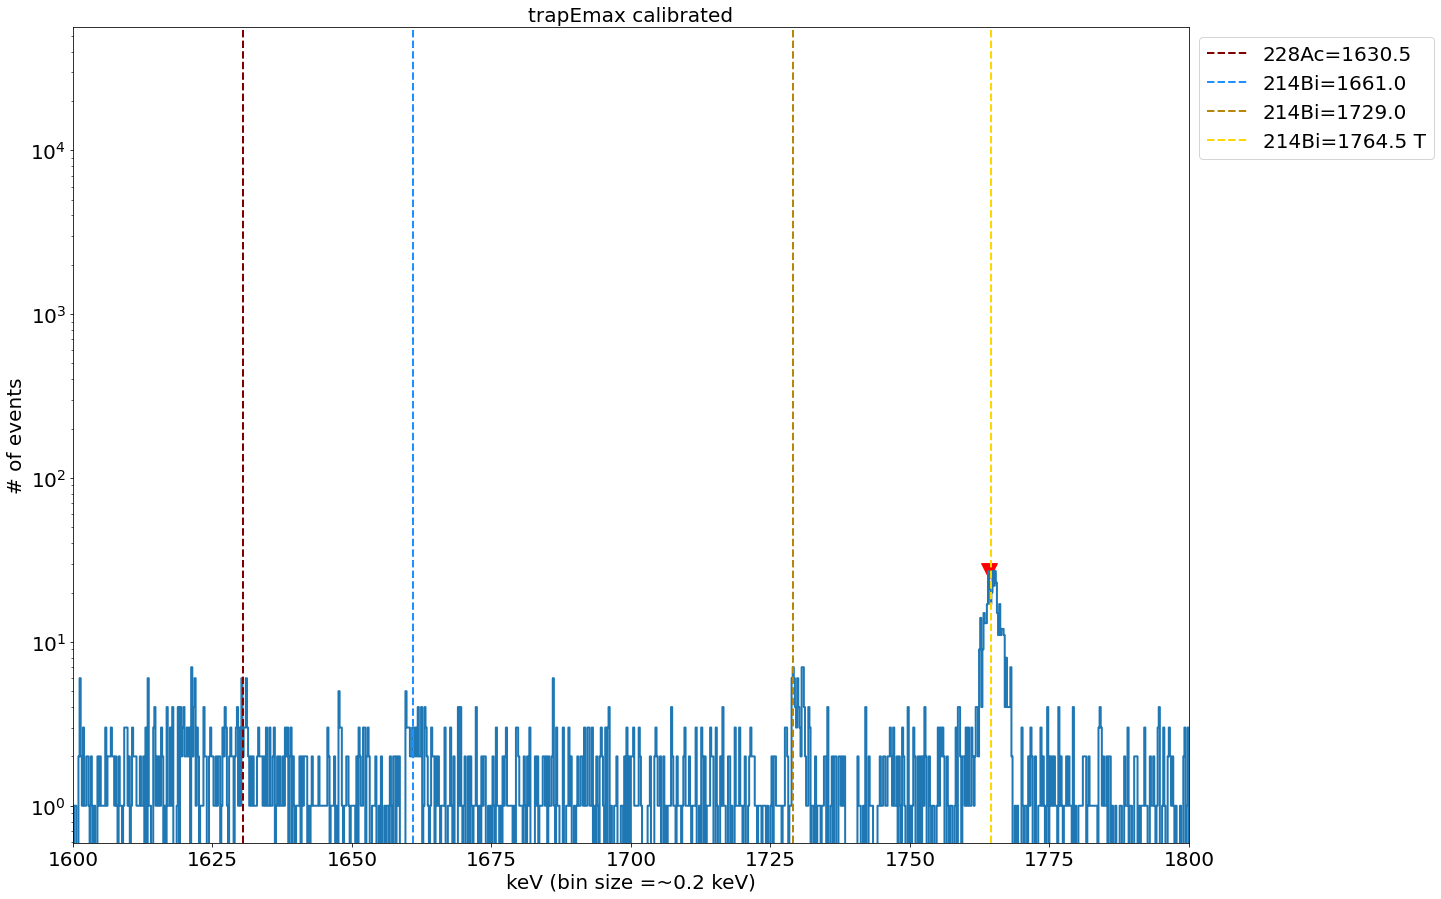

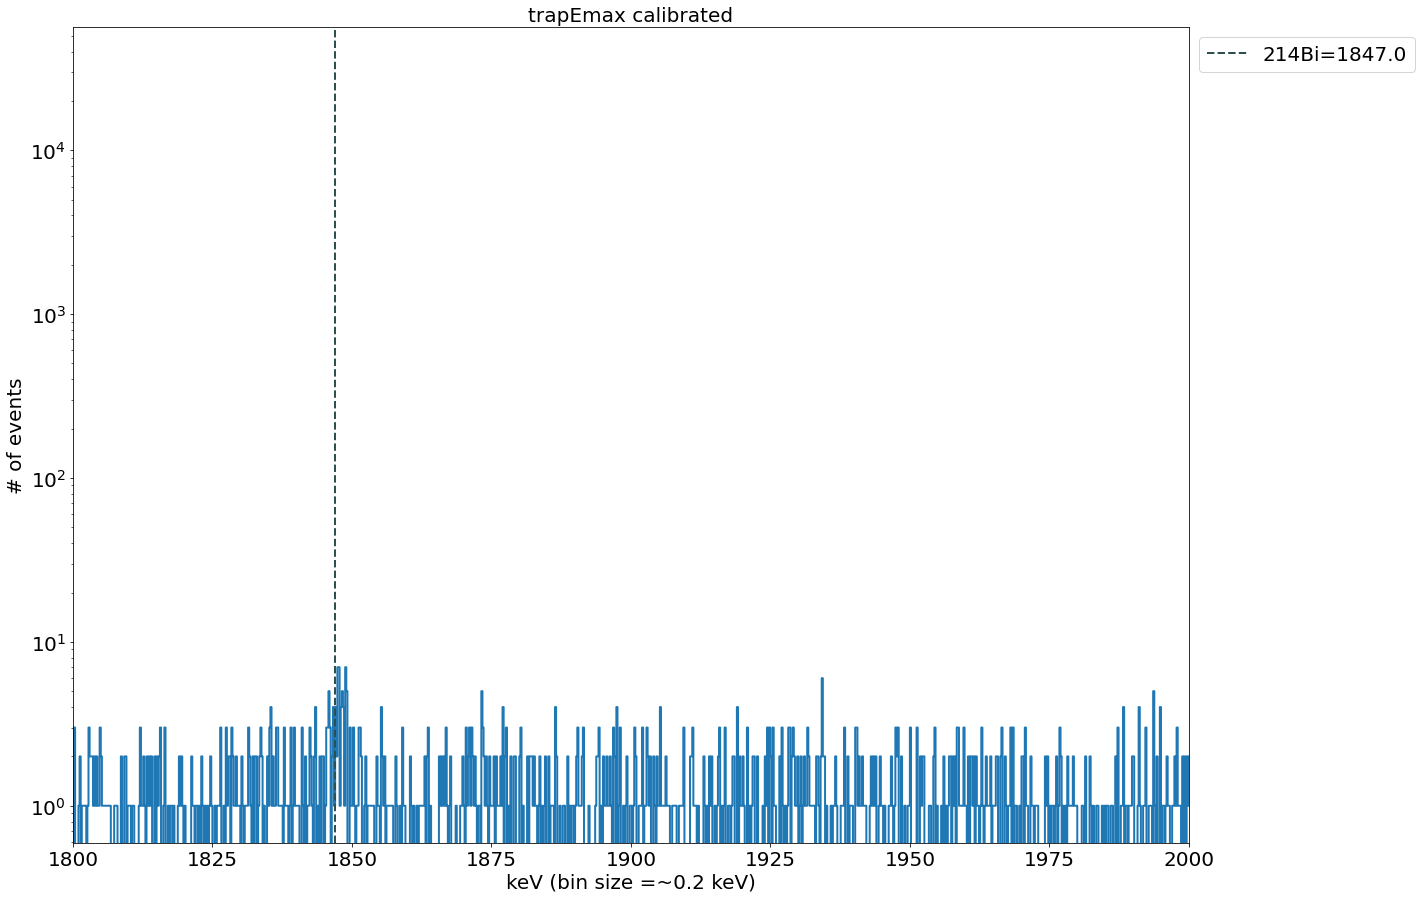

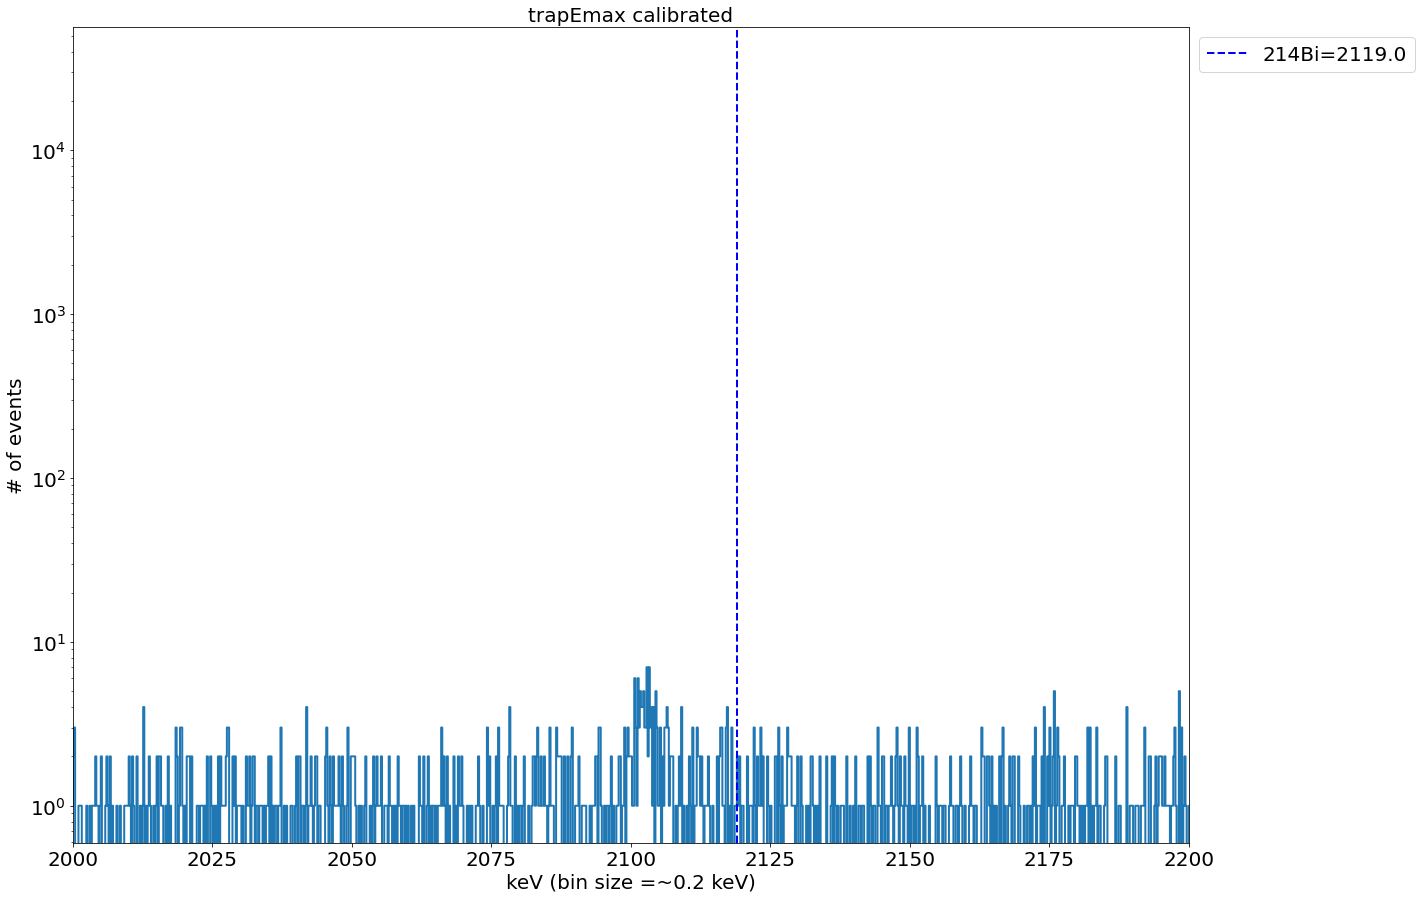

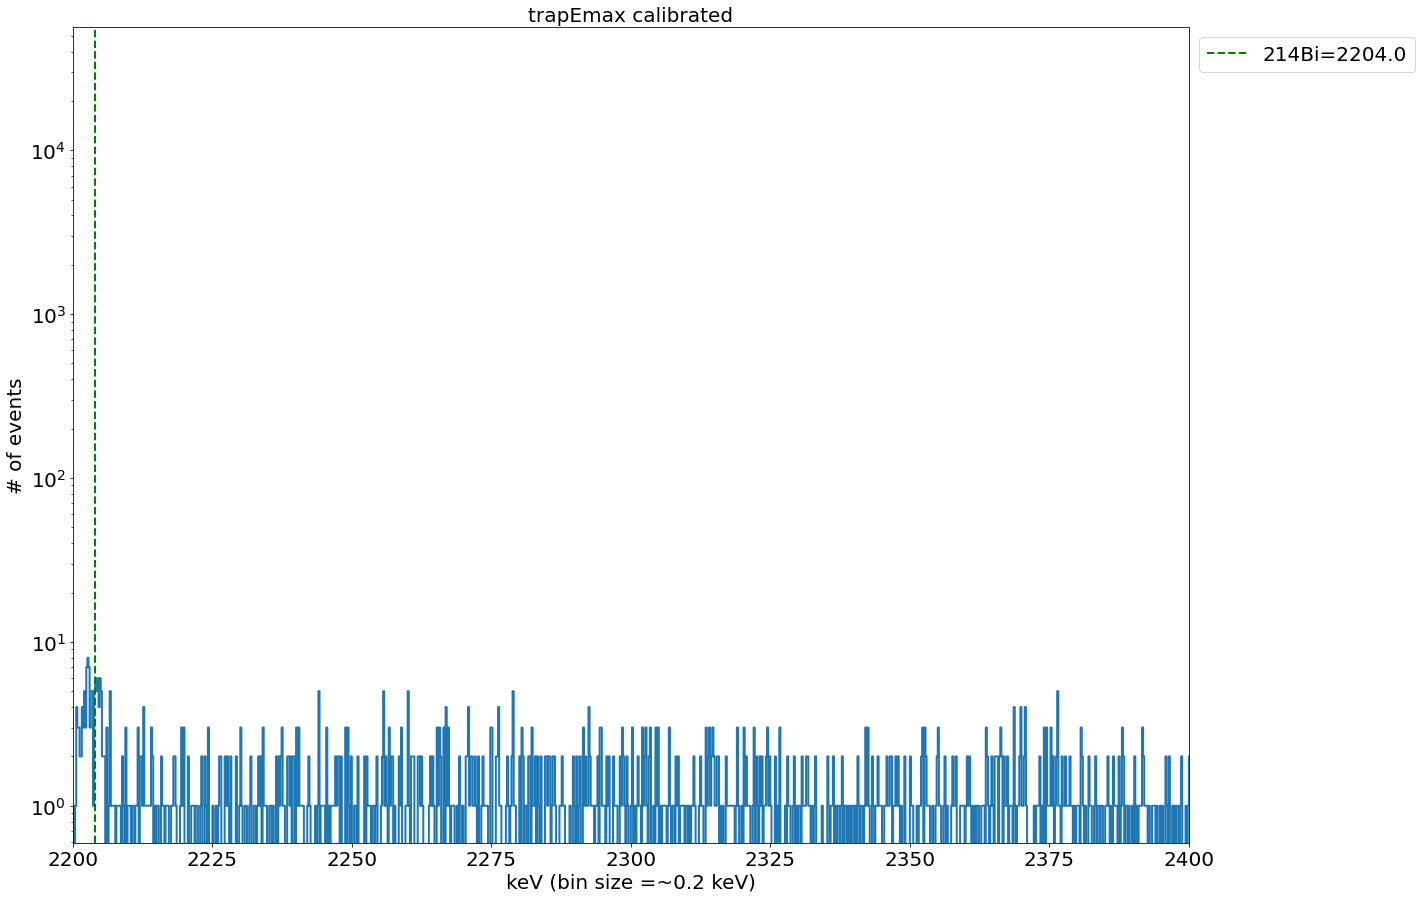

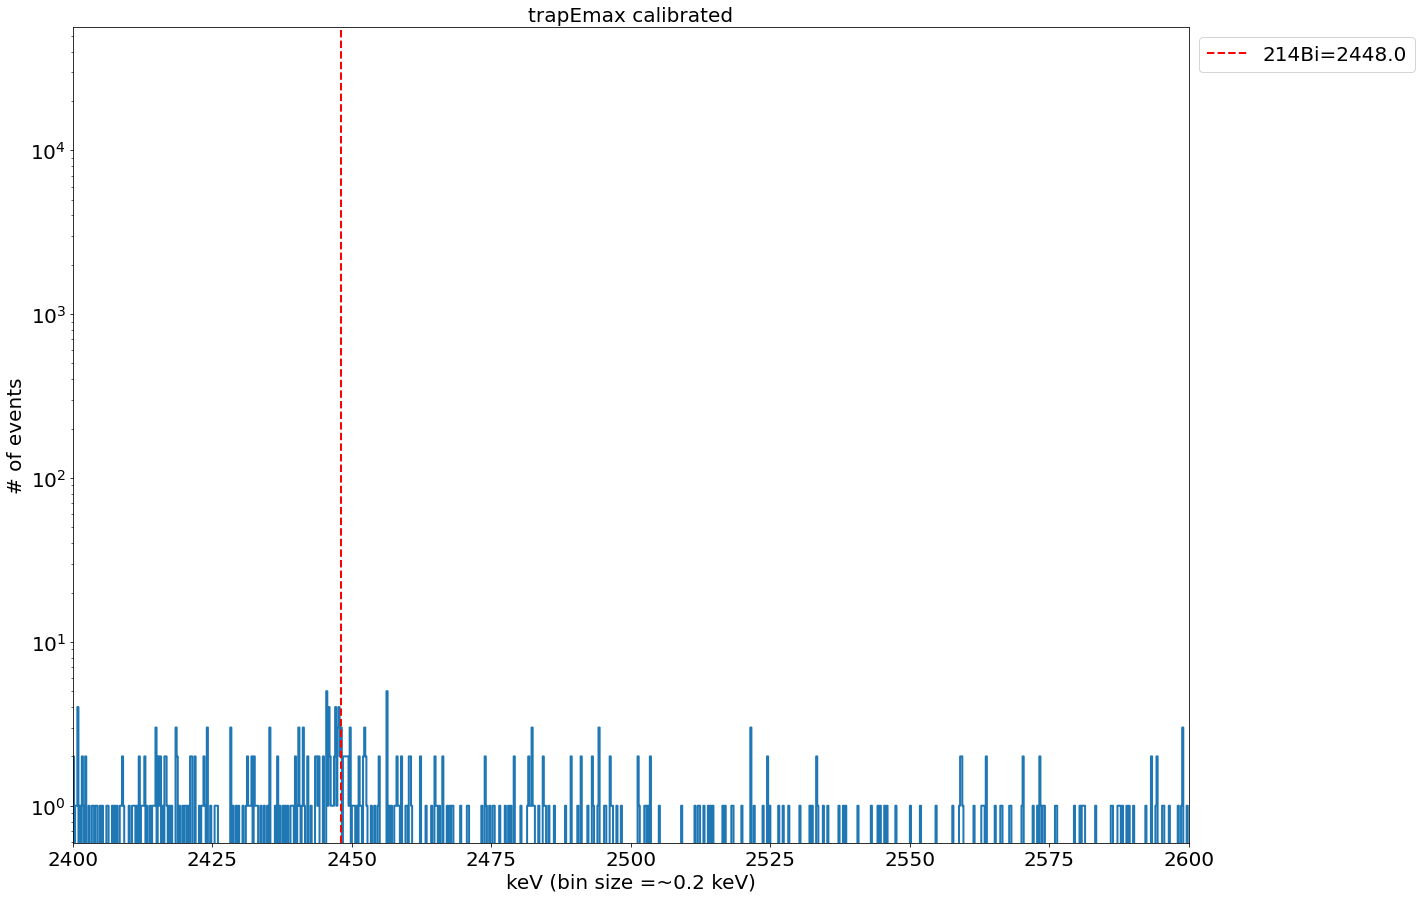

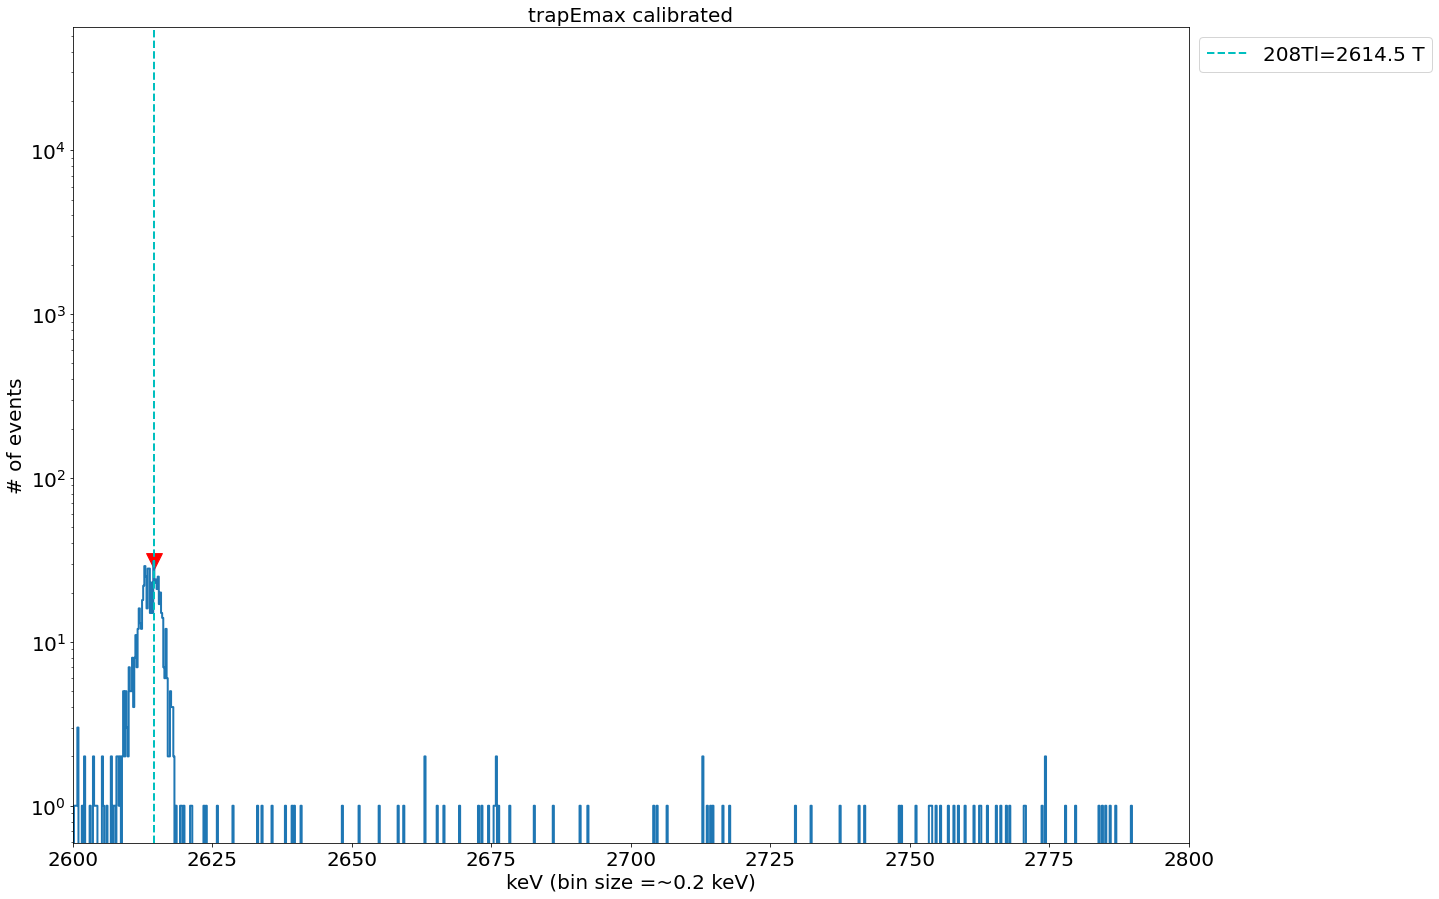

No handles with labels found to put in legend.


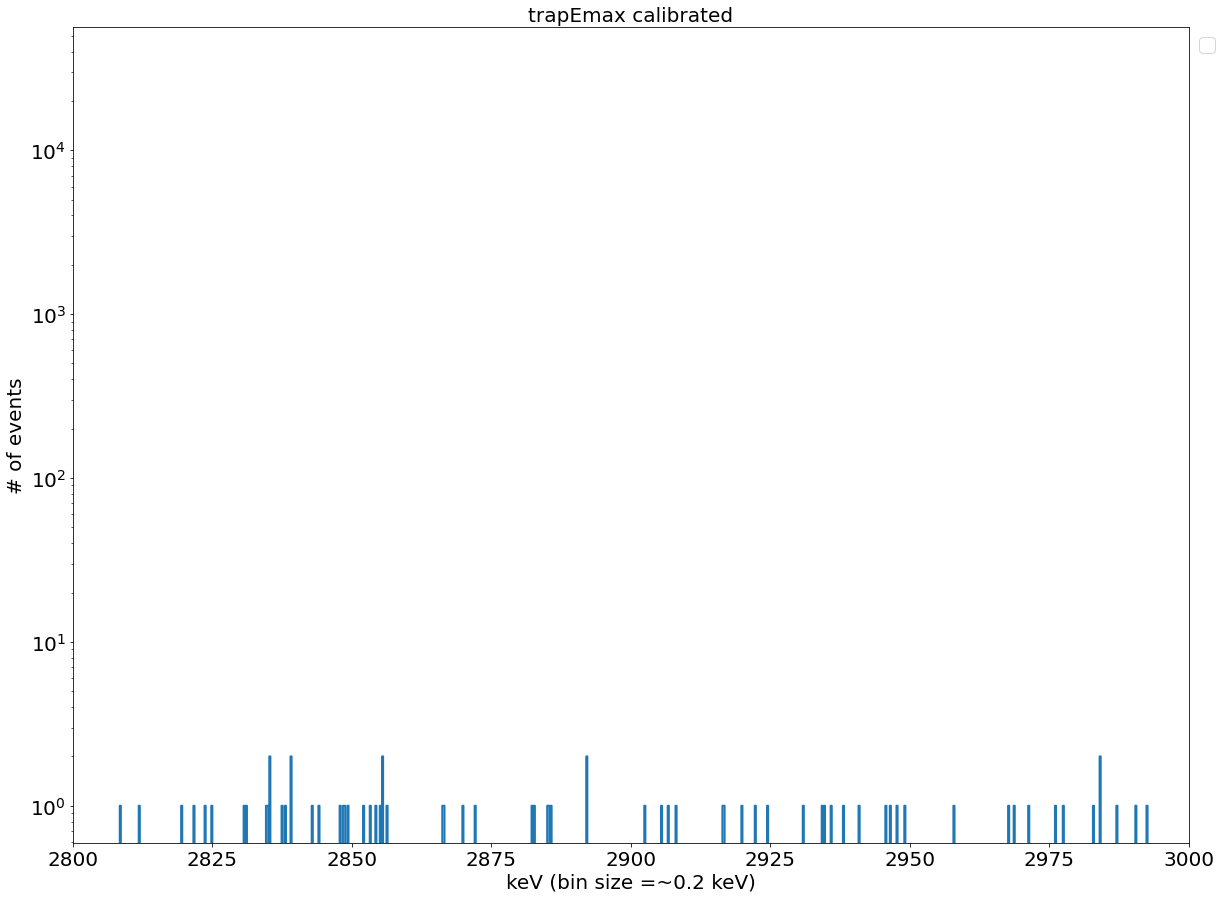

In [5]:
start = 0
end = 2800
while start<=end:
    print_a_range(start, start+200, tall_peaks=False, figsize=(20,15))
    start=start+200

In [6]:
'''
big_peaks_keV = np.asarray(peak_list_tall['e_kev'])
found_peaks, pars = cb.hpge_find_E_peaks(hist, bins, var, big_peaks_keV, 
                                         deg=0, 
                                         n_sigma=7)
print(found_peaks)
'''

"\nbig_peaks_keV = np.asarray(peak_list_tall['e_kev'])\nfound_peaks, pars = cb.hpge_find_E_peaks(hist, bins, var, big_peaks_keV, \n                                         deg=0, \n                                         n_sigma=7)\nprint(found_peaks)\n"

In [7]:
imaxes

array([    4,    14,   102,   712,   780,  1195,  1368,  1476,  1691,
        1761,  2046,  2554,  2687,  2735,  2915,  3047,  3393,  3416,
        3636,  3840,  3973,  4554,  4666,  4842,  5600,  5768,  6241,
        7305,  8820, 13072])

In [8]:
def matched_peaks(bin_centers, imaxes, known_peaks, tol=5):
    matched_peaks = []
    for peak in known_peaks:
        for imax in imaxes:
            if bin_centers[imax]<peak+tol and bin_centers[imax]>peak-tol:
                matched_peaks.append(bin_centers[imax])
                break
    return matched_peaks

tall_peaks = np.asarray(peak_list_tall['e_kev'])
tol = 5
big_peaks = []
for peak in tall_peaks:
    #print(peak)
    for imax in imaxes:
        #print(imax)
        #print(bin_centers[imax])
        if bin_centers[imax]<peak+tol and bin_centers[imax]>peak-tol:
            big_peaks.append(bin_centers[imax])
            break


unknown_peaks = [186.1, 273.5, 409.3, 463.1, 546.9, 683.3, 727.5, 1587.9]
for peak in unknown_peaks:
    bs.insort(big_peaks, peak)

print(big_peaks)

#ppp = matched_peaks(bin_centers, imaxes, tall_peaks)
#print(ppp)

[186.1, 239.1, 273.5, 295.3, 352.3, 409.3, 463.1, 510.9, 546.9, 583.1, 609.5, 683.3, 727.5, 910.9, 968.5, 1120.1, 1461.1, 1587.9, 1764.1, 2614.5]


In [9]:
big_peaks = unknown_peaks
poissonLL = []
for i in range(len(big_peaks)): poissonLL.append(False)
#print(poissonLL)
n_to_fit = 32
#hist, bins, var = pgh.get_hist(energy_calibrated, bins = n_bins, 
#                               range=adc_range)
pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, big_peaks, poissonLL, n_to_fit=n_to_fit)
#print(pt_pars[:,0])
mu1s = pt_pars[:,0]
pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, mu1s, poissonLL,
                                           n_to_fit=n_to_fit)
#pt_pars, pt_covs = fit_gaussian_once(hist, bins, var, pt_pars,
 #                                    n_to_fit=n_to_fit)
#print(pt_pars[:,0])
peaks = {'$\mu$ (keV)':pt_pars[:,0],
       '$\sigma$ (keV)':pt_pars[:,1],
       'Amplitude':pt_pars[:,2]
        }
pd.DataFrame(peaks)

,$\mu$ (keV),$\sigma$ (keV),Amplitude
0,185.8,6.1,196.2
1,273.7,0.4,"11,715.6"
2,408.5,4.8,48.2
3,463.1,4.4,38.2
4,546.9,2.2,39.5
5,683.4,0.4,"12,109.9"
6,727.2,2.8,22.4
7,"1,587.2",4.7,2.8


196.1905690384946


NameError: name 'found_peaks' is not defined

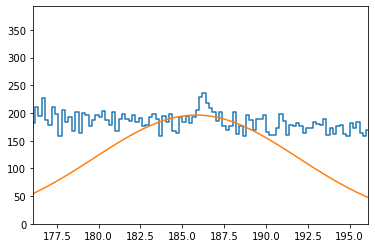

In [10]:
pgh_formatted = True
errorbar = False
markers = False
log_scale = False
adc_per_bin = 0.4
import pygama.analysis.peak_fitting as pgf

def zoom_in_around(val, tolerance = 20):
    if pgh_formatted:
        if errorbar:
            pgh.plot_hist(hist, bins,var) 
        else:
            pgh.plot_hist(hist,bins)
            #plt.ylim(0.1,1.1*np.amax(hist))
    else: plt.hist(energy_uncalibrated, bins=n_bins)
    if markers: plt.plot(bin_centers[imaxes], hist[imaxes], lw=0, marker='v')
    if log_scale: plt.yscale('log')

    plt.xlim(val-tolerance,val+tolerance)
    #plt.title('Location of extremas on hist of energy_uncalibrated (log scale)', fontsize=title_fontsize)

def plot_gaussian_at_peak(i):
    peak = big_peaks[i]
    zoom_in_around(peak, tolerance=10)
    print(pt_pars[i,2])
    plt.ylim(0,2*pt_pars[i,2])
    pgu.plot_func(pgf.gauss_basic, pt_pars[i],
                 range=(peak-0.5*n_to_fit,peak+0.5*n_to_fit))
    plt.title('poisson LL='+str(poissonLL[2])+', fit range='+str(n_to_fit) +
              '\n[$\mu$, $\sigma$, A]='+str(pt_pars[i])+'\n found peak='+str(found_peaks[i]))
    plt.show()
    

#plot_gaussian_at_peak(9)
for i in range(len(mu1s)):
    plot_gaussian_at_peak(i)

In [ ]:
bin_centers[imaxes]

In [ ]:
peaks = peak_list.iloc[:,1]
current_pars=[0.44952624,0.23851961]
current_inv_pars=[1/current_pars[0], current_pars[1]*(-1)/current_pars[1]]
m_peaks = []
residuals = []
for peak in peak_list.iloc[:,1]:
    #print(type(peak))

    for bin_center in bin_centers[imaxes]:
        if np.abs(peak-bin_center)<1:
            #print(peak, bin_center)
            m_peaks.append(bin_center)
            residuals.append(bin_center-peak)
            break
m_peaks
print(m_peaks, peaks)
peaks_with_error = [351.9, 583.2, 609.32, 911.2, 1460.8, 1764.5]
#residuals_of_peaks_with_error = [ 0.0859027  , 0.00954721, -0.00346806, -0.06356575 ,
 #                                0.00585202 ,-0.0342785 ]
residuals_of_peaks_with_error = [ 0.2872764  , -0.0180755 , -0.05073102 , -0.24622598 ,
                                 0.0107681 ,  0.31514424]
errors = [0.12054374 ,0.10327066, 0.05771364, 0.15110752, 0.06091846, 0.25012666]
plt.scatter(m_peaks, residuals, marker='o')
plt.errorbar(peaks_with_error, residuals_of_peaks_with_error, yerr=errors, fmt='o', c='r')